# Earthquake Detection Using Seisbench 

In recent years, seismology has significantly benefited from machine learning (ML), which enhances efficiency, accuracy, and scope in earthquake detection. ML automates vast data processing, reducing manual effort and enabling real-time monitoring. It improves detection accuracy by recognizing patterns and anomalies often missed by traditional methods. ML models are adaptable and scalable, suitable for various regions and capable of analyzing global seismic data simultaneously. This notebook demonstrates the integration of Seisbench a common package used for ML studies, into an earthquake detection workflow.

- [Seisbench Documentation](https://github.com/seisbench/seisbench)
- [PhaseNet Documentation](https://github.com/AI4EPS/PhaseNet)
- [GaMMA Documentation](https://github.com/AI4EPS/GaMMA)

This notebook also leverages **parallel processing**, a method that allows multiple computations to be carried out simultaneously, significantly speeding up data analysis by utilizing multiple CPU cores concurrently.

**Author:** Marc Garcia, University of Texas - El Paso, magarcia58@miners.utep.edu

In [1]:
# intall necessary packages for notebook
!pip install seisbench
!pip install git+https://github.com/AI4EPS/GaMMA.git

  Using cached seisbench-0.7.2-py3-none-any.whl.metadata (10 kB)
  Using cached torch-2.3.1-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Using cached filelock-3.15.4-py3-none-any.whl.metadata (2.9 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86

# Select Region of Interest(Cascadia Subduction Zone)

The Cascadia Subduction Zone is a major fault line stretching from northern California to British Columbia, where the Juan de Fuca Plate is subducting beneath the North American Plate. This region is known for producing significant seismic activity, including potential megathrust earthquakes. For this study, we chose the UW (University of Washington) seismic network, which provides extensive coverage and high-quality seismic data for the Cascadia region, making it ideal for testing and demonstrating our machine learning-based earthquake detection workflow.

In [2]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

# Define the client and geographic bounds of the Cascadia Subduction Zone
client = Client("IRIS")
degree2km = 111
min_latitude = 40.0
max_latitude = 50.0
min_longitude = -125.0
max_longitude = -120.0

# Fetch station metadata within the defined region for the PNSN network UW, with desired channels
inventory = client.get_stations(network="UW", minlatitude=min_latitude, maxlatitude=max_latitude,
                                minlongitude=min_longitude, maxlongitude=max_longitude,
                                channel="HH*", level="response")  # Fetch response-level metadata

# Define the function to process each station and channel
def process_station(network, station):
    station_list = []
    for channel in station:
        if channel.code[:2] == 'HH':  # Filter for desired channels
            # Check if the channel is active in 2024
            if channel.start_date <= UTCDateTime('2024-12-31') and (channel.end_date is None or channel.end_date >= UTCDateTime('2024-01-01')):
                station_info = {
                    'id': f"{network.code}.{station.code}.",
                    'Network': network.code,
                    'Station': station.code,
                    'Latitude': station.latitude,
                    'Longitude': station.longitude,
                    'Elevation': station.elevation,
                    'Sample Rate': channel.sample_rate
                }
                station_list.append(station_info)
    return station_list

# Use ThreadPoolExecutor to process stations in parallel
station_list = []
with ThreadPoolExecutor() as executor:
    futures = []
    for network in inventory:
        for station in network:
            futures.append(executor.submit(process_station, network, station))
    
    for future in futures:
        station_list.extend(future.result())

# Create DataFrame
station_df = pd.DataFrame(station_list)

# Remove duplicate stations
station_df = station_df.drop_duplicates(subset=['id'])

# Randomly select 50 stations (for testing purposes, comment out if you want full station list)
if len(station_df) > 50:
    station_df = station_df.sample(n=50)

# Display the DataFrame
print(station_df)


            id Network Station   Latitude   Longitude  Elevation  Sample Rate
387   UW.WYNO.      UW    WYNO  47.433920 -123.612960      935.4        100.0
24     UW.BHW.      UW     BHW  47.836360 -122.030570      152.0        100.0
48     UW.CBS.      UW     CBS  47.804690 -120.042850     1067.0        100.0
282   UW.RATT.      UW    RATT  47.425460 -121.802540      442.4        100.0
9     UW.ASR2.      UW    ASR2  46.139699 -121.597405     1273.8        100.0
306   UW.SHUK.      UW    SHUK  48.852840 -121.676950     1516.0        100.0
228    UW.MOX.      UW     MOX  46.577004 -120.299609      504.2        100.0
90    UW.DOTY.      UW    DOTY  46.704640 -123.369230      429.8        100.0
72   UW.CROWN.      UW   CROWN  48.302930 -124.478840      399.4        100.0
54   UW.CHIMA.      UW   CHIMA  48.010510 -122.780580       38.4        100.0
51     UW.CDF.      UW     CDF  46.117120 -122.046250      772.0        100.0
69    UW.COYL.      UW    COYL  47.697110 -122.788160       95.9

### Let's now visualize the selected seismic stations within the Cascadia region to better understand their distribution and coverage.

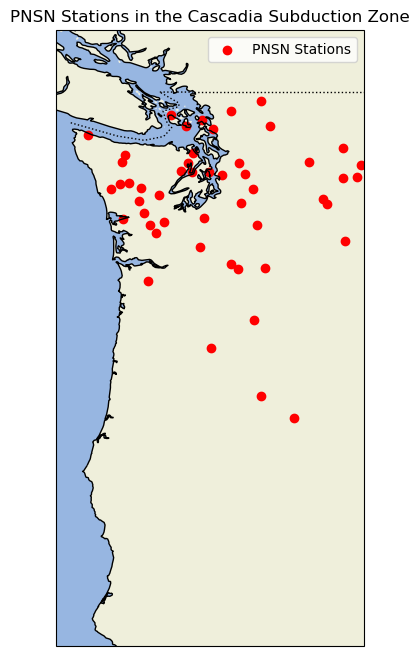

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Extract station coordinates for the filtered stations
stations = station_df[['Latitude', 'Longitude']].values.tolist()

# Create a plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map bounds
ax.set_extent([min_longitude, max_longitude, min_latitude, max_latitude], crs=ccrs.PlateCarree())

# Plot the stations
if stations:
    lats, lons = zip(*stations)
    ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree(), label='PNSN Stations')

# Add labels and title
ax.set_title('PNSN Stations in the Cascadia Subduction Zone')
ax.legend()

# Show the plot
plt.show()

# Phase Picking with PhaseNet (Seisbench) 

In [11]:
from obspy import UTCDateTime, Stream
import pandas as pd
from collections import Counter
import seisbench.models as sbm
import time
from concurrent.futures import ThreadPoolExecutor, as_completed

picker = sbm.PhaseNet.from_pretrained("original")

# Initialize a single catalog for picks
pick_list = []

# Define start and end times for the period of interest
start_time = UTCDateTime("2024-01-01T00:00:00")
end_time = UTCDateTime("2024-01-01T02:00:00")
window_time = 7200  # 1 hour windows for fetching data

# Function to fetch waveform data for a given station
def fetch_waveform_data(station, current_time, window_time):
    try:
        stream = client.get_waveforms(
            network=station['Network'],
            station=station['Station'],
            location="*",
            channel="HH?",
            starttime=current_time,
            endtime=current_time + window_time
        )
        return stream
    except Exception:
        return Stream()

# Loop through each time window
current_time = start_time

while current_time < end_time:
    combined_stream = Stream()
    
    # Measure the time taken to download data
    start_download_time = time.time()
    with ThreadPoolExecutor(max_workers=16) as executor:
        futures = [executor.submit(fetch_waveform_data, station, current_time, window_time) for station in station_list]
        for future in as_completed(futures):
            combined_stream += future.result()
    end_download_time = time.time()
    
    # Classify the combined stream using the PhaseNet picker if it is not empty
    if combined_stream:
        try:
            start_processing_time = time.time()
            picks = picker.classify(
                combined_stream, 
                batch_size=256, 
                P_threshold=0.075, 
                S_threshold=0.1
            ).picks
            end_processing_time = time.time()
            
            # Append picks to the catalog
            pick_list.extend([{
                "id": p.trace_id,
                "timestamp": p.peak_time.datetime,
                "prob": p.peak_value,
                "type": p.phase.lower()
            } for p in picks])
            
            # Print the count of P and S picks and the processing time
            pick_count = Counter(p.phase for p in picks)
            download_time = end_download_time - start_download_time
            processing_time = end_processing_time - start_processing_time
            print(f"Time window starting at {current_time}: {pick_count} (Download time: {download_time:.2f} seconds, Processing time: {processing_time:.2f} seconds)")
        
        except Exception as e:
            print(f"Error processing combined stream at {current_time}: {e}")
    
    # Move to the next time window
    current_time += window_time

# Convert the pick catalog to a DataFrame for further analysis or export
pick_df = pd.DataFrame(pick_list)

# Print the total number of picks
print(f"Total number of picks: {len(pick_df)}")

Time window starting at 2024-01-01T00:00:00.000000Z: Counter({'P': 1743, 'S': 993}) (Download time: 118.25 seconds, Processing time: 23.23 seconds)
Total number of picks: 2736


# Phase Association with GaMMA

## Configurations

In [48]:
from pyproj import CRS, Transformer

# Projections
wgs84 = CRS.from_epsg(4326)
local_crs = CRS.from_epsg(2992)  # NAD83(HARN) / Oregon North (ft)
transformer = Transformer.from_crs(wgs84, local_crs)

# Gamma
config = {}
config["dims"] = ['x(km)', 'y(km)', 'z(km)']
config["use_dbscan"] = True
config["use_amplitude"] = False
config["x(km)"] = (0, 2000)
config["y(km)"] = (0, 3000)
config["z(km)"] = (0, 150)
config["vel"] = {"p": 6.0, "s": 6.0 / 1.75}  
config["method"] = "BGMM"
if config["method"] == "BGMM":
    config["oversample_factor"] = 4
if config["method"] == "GMM":
    config["oversample_factor"] = 1

# DBSCAN
config["bfgs_bounds"] = (
    (config["x(km)"][0] - 1, config["x(km)"][1] + 1),  # x
    (config["y(km)"][0] - 1, config["y(km)"][1] + 1),  # y
    (0, config["z(km)"][1] + 1),  # x
    (None, None),  # t
)
config["dbscan_eps"] = 60  # seconds
config["dbscan_min_samples"] = 3

# Filtering
config["min_picks_per_eq"] = 3
config["max_sigma11"] = 2.0
config["max_sigma22"] = 1.0
config["max_sigma12"] = 1.0

station_df["x(km)"] = station_df.apply(lambda x: transformer.transform(x["Latitude"], x["Longitude"])[0] / 1e3, axis=1)
station_df["y(km)"] = station_df.apply(lambda x: transformer.transform(x["Latitude"], x["Longitude"])[1] / 1e3, axis=1)
station_df["z(km)"] = station_df["Elevation"] / 1e3

northing = {station: y for station, y in zip(station_df["id"], station_df["y(km)"])}
station_dict = {station: (x, y) for station, x, y in zip(station_df["id"], station_df["x(km)"], station_df["y(km)"])}



## Association with GaMMA

In [61]:
from gamma.utils import association

catalogs, assignments = association(pick_df, station_df, config, method=config["method"])

catalog = pd.DataFrame(catalogs)
assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gamma"])

Associating 24 clusters with 6 CPUs
........................

In [62]:
print(catalog)

                       time  magnitude  sigma_time  sigma_amp  cov_time_amp  \
0   2024-01-01T01:36:35.998        999    0.670420          0             0   
1   2024-01-01T01:31:55.435        999    0.344392          0             0   
2   2024-01-01T01:32:02.554        999    0.235577          0             0   
3   2024-01-01T01:32:31.118        999    0.239069          0             0   
4   2024-01-01T01:01:33.065        999    0.578419          0             0   
..                      ...        ...         ...        ...           ...   
61  2024-01-01T01:49:46.288        999    0.679298          0             0   
62  2024-01-01T01:49:39.331        999    0.645382          0             0   
63  2024-01-01T01:27:25.838        999    0.396778          0             0   
64  2024-01-01T01:27:42.898        999    0.518498          0             0   
65  2024-01-01T01:26:43.359        999    0.421491          0             0   

    gamma_score  num_picks  num_p_picks  num_s_pick

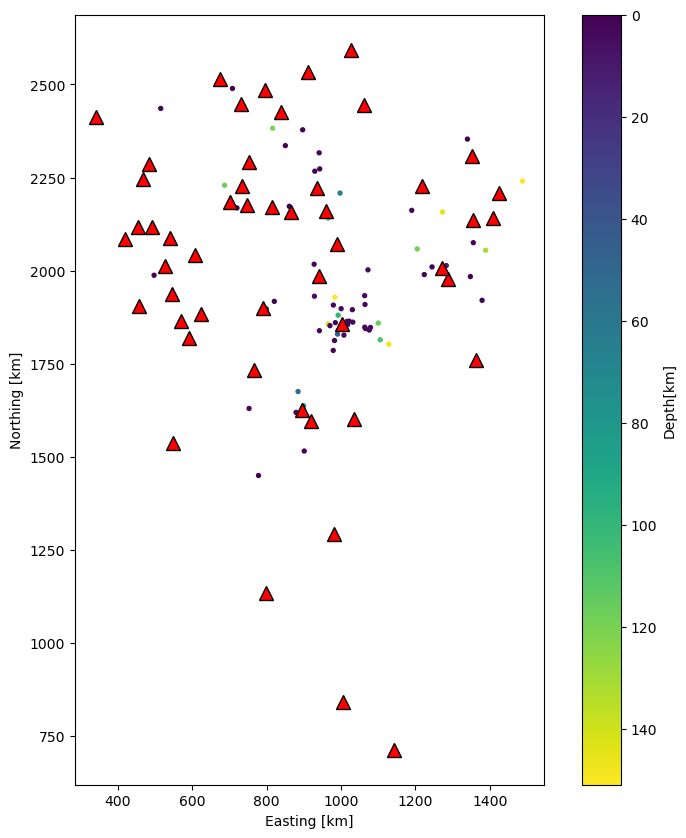

In [63]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.set_aspect("equal")
cb = ax.scatter(catalog["x(km)"], catalog["y(km)"], c=catalog["z(km)"], s=8, cmap="viridis")
cbar = fig.colorbar(cb)
cbar.ax.set_ylim(cbar.ax.get_ylim()[::-1])
cbar.set_label("Depth[km]")

ax.plot(station_df["x(km)"], station_df["y(km)"], "r^", ms=10, mew=1, mec="k")
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
plt.show()

In [50]:
# Calculate the centroid of x and y coordinates
centroid_x = catalog['x(km)'].mean()
centroid_y = catalog['y(km)'].mean()

print(f"Centroid X: {centroid_x} km, Centroid Y: {centroid_y} km")

# Define the CRS and transformer
wgs84 = CRS.from_epsg(4326)
local_crs = CRS.from_epsg(2992)  # NAD83(HARN) / Oregon North (ft)
transformer = Transformer.from_crs(local_crs, wgs84)

# Convert the centroid back to lat/lon
centroid_lon, centroid_lat = transformer.transform(centroid_x * 1e3, centroid_y * 1e3)  # Convert km to meters for the transformation

print(f"Centroid Latitude: {centroid_lat}, Centroid Longitude: {centroid_lon}")

Centroid X: 998.6854750258058 km, Centroid Y: 1975.6636075048318 km
Centroid Latitude: -121.759489766386, Centroid Longitude: 47.16178680018871


In [58]:
# New center coordinates
center_latitude = 47.16178680018871
center_longitude = -121.759489766386

# Define the CRS and transformer
wgs84 = CRS.from_epsg(4326)
local_crs = CRS(proj='aeqd', lat_0=center_latitude, lon_0=center_longitude)
transformer = Transformer.from_crs(local_crs, wgs84)

# Define a function to convert x and y distances to lat and lon
def convert_to_lat_lon(row):
    x_m = row['x(km)']
    y_m = row['y(km)']
    
    
    # Transform from xy to latlon
    lat, lon = transformer.transform(x_m, y_m)
    
    return pd.Series([lat, lon], index=['latitude', 'longitude'])

# Apply the function to the DataFrame
catalog[['latitude', 'longitude']] = catalog.apply(convert_to_lat_lon, axis=1)

print(catalog[['time', 'latitude', 'longitude']])

                       time   latitude   longitude
0   2024-01-01T01:57:30.352  47.178555 -121.746011
1   2024-01-01T01:58:20.520  47.178339 -121.745297
2   2024-01-01T01:58:36.272  47.179930 -121.747249
3   2024-01-01T01:36:35.998  47.181232 -121.743790
4   2024-01-01T00:26:14.451  47.178217 -121.746194
..                      ...        ...         ...
61  2024-01-01T00:32:46.184  47.174825 -121.749222
62  2024-01-01T00:33:55.249  47.180450 -121.741608
63  2024-01-01T00:34:54.885  47.179632 -121.741713
64  2024-01-01T01:49:46.288  47.179033 -121.748661
65  2024-01-01T01:49:39.331  47.178324 -121.747063

[66 rows x 3 columns]


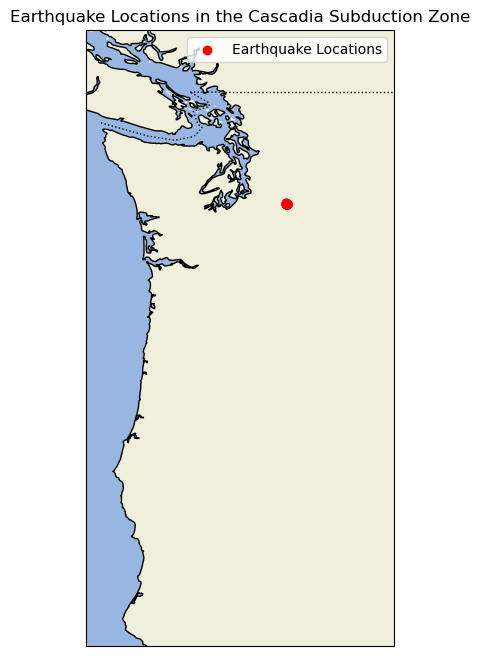

In [60]:
# Extract earthquake coordinates from catalog
earthquakes = catalog[['latitude', 'longitude']].values.tolist()

min_latitude = 40.0
max_latitude = 50.0
min_longitude = -125.0
max_longitude = -120.0

# Create a plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add geographic features
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Set the map bounds
ax.set_extent([min_longitude, max_longitude, min_latitude, max_latitude], crs=ccrs.PlateCarree())

# Plot the earthquake locations
if earthquakes:
    lats, lons = zip(*earthquakes)
    ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree(), label='Earthquake Locations')

# Add labels and title
ax.set_title('Earthquake Locations in the Cascadia Subduction Zone')
ax.legend()

# Show the plot
plt.show()
